In [1]:
import os
os.environ["HF_HOME"] = "/tmp/wendler/hf_cache"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import argparse
import sys
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

# Add necessary paths for custom modules
sys.path.append("/share/u/wendler/code/my-sdxl-unbox")

from SDLens import HookedStableDiffusionXLPipeline
from SAE import SparseAutoencoder
from utils import add_feature_on_area_turbo

import supervision as sv
import pycocotools.mask as mask_util
from torchvision.ops import box_convert

# Grounded SAM2 and Grounding DINO imports
sys.path.append("/share/u/wendler/code/Grounded-SAM-2")
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from grounding_dino.groundingdino.util.inference import load_model, predict
import grounding_dino.groundingdino.datasets.transforms as T


In [2]:

n_steps = 4
m1 = 1.
k_transfer = 5
use_down = True
use_up = True
use_up0 = True
use_mid = True

In [3]:
code_to_block = {
        "down.2.1": "unet.down_blocks.2.attentions.1",
        "up.0.1": "unet.up_blocks.0.attentions.1",
        "up.0.0": "unet.up_blocks.0.attentions.0",
        "mid.0": "unet.mid_block.attentions.0",
    }

In [4]:
# Add SDLens/src to sys.path at the top of the scrip

# --- Utility functions ---
def resize_mask(mask, size=(16, 16)):
    # consider all 32 by 32 windows in the mask
    small = cv2.resize(mask.astype(np.float32), size, interpolation=cv2.INTER_LANCZOS4) > 0
    if small.astype(np.float32).sum() == 0:
        tmp = mask.reshape(16, 32, 16, 32).astype(np.float32)
        tmp = tmp.sum(axis=1)
        tmp = tmp.sum(axis=2)
        if (tmp >= 32*32).astype(np.float32).sum() == 0:
            print("trying to fix the mask...")
            # set the maximum gridcell to 1
            amax = tmp.argmax()
            tmp[np.unravel_index(amax, tmp.shape)] = 1
            return tmp.astype(bool)
    return small

from matplotlib import pyplot as plt
from typing import Tuple
import grounding_dino.groundingdino.datasets.transforms as T

def sam_mask(img, prompt, sam2_predictor, grounding_model, BOX_THRESHOLD, TEXT_THRESHOLD):
    def load_image(img) -> Tuple[np.array, torch.Tensor]:
        transform = T.Compose(
            [
                T.RandomResize([800], max_size=1333),
                T.ToTensor(),
                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
        image_source = img.convert("RGB")
        image = np.asarray(image_source)
        image_transformed, _ = transform(image_source, None)
        return image, image_transformed
    image_source, image = load_image(img)
    sam2_predictor.set_image(image_source)

    boxes, confidences, labels = predict(
        model=grounding_model,
        image=image,
        caption=prompt,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD,
    )

    # process the box prompt for SAM 2
    h, w, _ = image_source.shape
    boxes = boxes * torch.Tensor([w, h, w, h])
    input_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()


    # FIXME: figure how does this influence the G-DINO model
    # torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

    #if torch.cuda.get_device_properties(0).major >= 8:
        # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
        #torch.backends.cuda.matmul.allow_tf32 = True
        #torch.backends.cudnn.allow_tf32 = True

    masks, scores, logits = sam2_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_boxes,
        multimask_output=False,
    )

    """
    Post-process the output of the model to get the masks, scores, and logits for visualization
    """
    # convert the shape to (n, H, W)
    if masks.ndim == 4:
        masks = masks.squeeze(1)


    confidences = confidences.numpy().tolist()
    class_names = labels

    class_ids = np.array(list(range(len(class_names))))

    labels = [
        f"{class_name} {confidence:.2f}"
        for class_name, confidence
        in zip(class_names, confidences)
    ]

    detections = sv.Detections(
        xyxy=input_boxes,  # (n, 4)
        mask=masks.astype(bool),  # (n, h, w)
        class_id=class_ids
    )

    box_annotator = sv.BoxAnnotator()
    annotated_frame = box_annotator.annotate(scene=img.copy(), detections=detections)

    label_annotator = sv.LabelAnnotator()
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    mask_annotator = sv.MaskAnnotator()
    annotated_frame = mask_annotator.annotate(scene=annotated_frame, detections=detections)
    return detections, labels, annotated_frame
    

def best_features_saeuron(source_feats, target_feats, k=10):
    mean_source = source_feats.mean(dim=0).mean(dim=0)
    mean_target = target_feats.mean(dim=0).mean(dim=0)
    scores = mean_source/mean_source.sum() - mean_target/mean_target.sum()
    arg_sorted = np.argsort(scores.cpu().detach().numpy())
    return arg_sorted[::-1][:k].copy(), arg_sorted[:k].copy()

@torch.no_grad()
def get_features_per_block(cache1, cache2, mask1, mask2, k_transfer=None, blocks_to_intervene=None, saes=None):
    print(blocks_to_intervene)
    to_source_features_dict = {}
    to_target_features_dict = {}
    source_feats_dict = {}
    target_feats_dict = {}
    source_dict = {}
    target_dict = {}
    for shortcut in blocks_to_intervene:
        block = code_to_block[shortcut]
        diff1 = cache1['output'][block][0] - cache1['input'][block][0]
        diff2 = cache2['output'][block][0] - cache2['input'][block][0]
        source = diff1[:, :, mask1]
        target = diff2[:, :, mask2]
        sae = saes[shortcut]
        source_feats = sae.encode(source.permute(0, 2, 1))
        target_feats = sae.encode(target.permute(0, 2, 1))
        to_source_features, to_target_features = best_features_saeuron(source_feats, target_feats, k=k_transfer)
        to_source_features_dict[shortcut] = to_source_features
        to_target_features_dict[shortcut] = to_target_features
        source_feats_dict[shortcut] = source_feats.detach().cpu()
        target_feats_dict[shortcut] = target_feats.detach().cpu()
        source_dict[shortcut] = source.detach().cpu()
        target_dict[shortcut] = target.detach().cpu()   
    return to_source_features_dict, to_target_features_dict, source_feats_dict, target_feats_dict, source_dict, target_dict
    
@torch.no_grad()
def get_features_all_blocks(cache1, cache2, mask1, mask2, k_transfer=None, blocks_to_intervene=None, saes=None):
    print("processing blocks jointly...")
    source_feats_all = []
    target_feats_all = []
    to_source_feats_dict = {}
    to_target_feats_dict = {}
    source_feats_dict = {}
    target_feats_dict = {}
    source_dict = {}
    target_dict = {}
    block_sizes = {}
    for shortcut in blocks_to_intervene:
        block = code_to_block[shortcut]
        diff1 = cache1['output'][block][0] - cache1['input'][block][0]
        diff2 = cache2['output'][block][0] - cache2['input'][block][0]
        source = diff1[:, :, mask1]
        target = diff2[:, :, mask2]
        sae = saes[shortcut]
        source_feats = sae.encode(source.permute(0, 2, 1))
        target_feats = sae.encode(target.permute(0, 2, 1))
        source_feats_all.append(source_feats)
        target_feats_all.append(target_feats)
        source_dict[shortcut] = source.detach().cpu()
        target_dict[shortcut] = target.detach().cpu()
        source_feats_dict[shortcut] = source_feats.detach().cpu() 
        target_feats_dict[shortcut] = target_feats.detach().cpu()
        block_sizes[shortcut] = source_feats.shape[-1]
    source_feats_all = torch.cat(source_feats_all, dim=-1)
    target_feats_all = torch.cat(target_feats_all, dim=-1)
    to_source_feats_all, to_target_feats_all = best_features_saeuron(source_feats_all, target_feats_all, k=k_transfer)
    start = 0
    for idx, shortcut in enumerate(blocks_to_intervene):
        to_source_feats = []
        to_target_feats = []
        for feat in to_source_feats_all:
            if feat >= start and feat < start+block_sizes[shortcut]:
                to_source_feats.append(feat-start)
        for feat in to_target_feats_all:
            if feat >= start and feat < start + block_sizes[shortcut]:
                to_target_feats.append(feat-start)
        to_source_feats_dict[shortcut] = np.asarray(to_source_feats)
        to_target_feats_dict[shortcut] = np.asarray(to_target_feats)
        start += block_sizes[shortcut]

    return to_source_feats_dict, to_target_feats_dict, source_feats_dict, target_feats_dict, source_dict, target_dict

In [5]:
dtype = torch.float16
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pipe = HookedStableDiffusionXLPipeline.from_pretrained(
    'stabilityai/sdxl-turbo',
    torch_dtype=dtype,
    device_map="balanced",
    variant=("fp16" if dtype==torch.float16 else None)
)
pipe.set_progress_bar_config(disable=True)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
SAM2_CHECKPOINT = "/share/u/wendler/code/Grounded-SAM-2/checkpoints/sam2.1_hiera_large.pt"
SAM2_MODEL_CONFIG = "configs/sam2.1/sam2.1_hiera_l.yaml"
GROUNDING_DINO_CONFIG = "/share/u/wendler/code/Grounded-SAM-2/grounding_dino/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT = "/share/u/wendler/code/Grounded-SAM-2/gdino_checkpoints/groundingdino_swint_ogc.pth"
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25
sam2_model = build_sam2(SAM2_MODEL_CONFIG, SAM2_CHECKPOINT, device=device)
sam2_predictor = SAM2ImagePredictor(sam2_model)
grounding_model = load_model(
    model_config_path=GROUNDING_DINO_CONFIG,
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT,
    device=device
)

path_to_checkpoints = '/share/u/wendler/code/my-sdxl-unbox/checkpoints/'
blocks = list(code_to_block.values())
saes = {}
k = 10
exp = 4
for shortcut in code_to_block.keys():
    block = code_to_block[shortcut]
    sae = SparseAutoencoder.load_from_disk(
        os.path.join(path_to_checkpoints, f"{block}_k{k}_hidden{exp*1280:d}_auxk256_bs4096_lr0.0001", "final")
    ).to(device, dtype=dtype)
    saes[shortcut] = sae

final text_encoder_type: bert-base-uncased


In [48]:
from functools import partial
# --- Main experiment ---
def add_featuremaps(sae, to_source_features, to_target_features, m1, fmaps, target_mask, module, input, output):
        diff = output[0] - input[0]
        coefs = sae.encode(diff.permute(0, 2, 3, 1))
        mask = torch.zeros([fmaps.shape[0], fmaps.shape[1], fmaps.shape[2], sae.decoder.weight.shape[1]], device=input[0].device)
        mask[0,target_mask][..., to_target_features] -= m1*coefs[0, target_mask][..., to_target_features]
        mask[..., to_source_features] += fmaps.to(mask.device)
        to_add = mask.to(sae.decoder.weight.dtype) @ sae.decoder.weight.T
        return (output[0] + to_add.permute(0, 3, 1, 2).to(output[0].device),)

def add_featuremaps_rescaling(sae, to_source_features, fmaps, module, input, output):
    mask = torch.zeros([fmaps.shape[0], fmaps.shape[1], fmaps.shape[2], sae.decoder.weight.shape[1]], device=input[0].device)
    mask[..., to_source_features] += fmaps.to(mask.device)
    to_add = mask.to(sae.decoder.weight.dtype) @ sae.decoder.weight.T
    out = output[0]/output[0].norm(dim=1, keepdim=True)
    out *= output[0].norm(dim=1, keepdim=True)  - to_add.permute(0, 3, 1, 2).norm(dim=1, keepdim=True)
    out += to_add.permute(0, 3, 1, 2).to(output[0].device)
    return (out, )

def ablation(sae, feature_idcs, fmaps, module, input, output):
    mask = torch.zeros([fmaps.shape[0], fmaps.shape[1], fmaps.shape[2], sae.decoder.weight.shape[1]], device=input[0].device)
    mask[..., feature_idcs] -= fmaps.to(mask.device)
    to_add = mask.to(sae.decoder.weight.dtype) @ sae.decoder.weight.T
    return (output[0] + to_add.permute(0, 3, 1, 2).to(output[0].device),)

def activation_patching(mean, target_mask, module, input, output):
    diff = output[0] - input[0]
    diff[0, :, target_mask] += mean[:, None]
    return (diff + input[0],)


def main(prompt1, prompt2, gsam_prompt1, gsam_prompt2, pipe=pipe, k=10, 
         blocks_to_intervene=["down.2.1", "up.0.1", "up.0.0", "mid.0"],
         n_steps=1, m1=2., k_transfer=10, stat="max", mode="sae_1", 
         combine_blocks=False,verbose=False,
         sam_predictor=sam2_predictor, grounding_model=grounding_model, saes=saes, 
         result_name=None):
    import logging
    logger = logging.getLogger(__name__)
    if verbose:
        logger.setLevel(logging.DEBUG)
    else:
        logger.setLevel(logging.INFO)    

    logger.debug("[4/9] Generating images and caching activations...")
    seed = 42
    base_imgs1, cache1 = pipe.run_with_cache(
        prompt1,
        positions_to_cache=blocks,
        num_inference_steps=n_steps,
        guidance_scale=0.0,
        generator=torch.Generator(device='cpu').manual_seed(seed),
        save_input=True,
    )
    base_imgs2, cache2 = pipe.run_with_cache(
        prompt2,
        positions_to_cache=blocks,
        num_inference_steps=n_steps,
        guidance_scale=0.0,
        generator=torch.Generator(device='cpu').manual_seed(seed),
        save_input=True,
    )
    img1 = base_imgs1[0][0]
    img2 = base_imgs2[0][0]

    logger.debug("[5/9] Running Grounded SAM on generated images...")
    if gsam_prompt1 == "background" or gsam_prompt1 == "#everything":
        mask1 = np.ones((16, 16), dtype=bool)
    else:
        detections1, labels1, annotated_frame1 = sam_mask(img1, gsam_prompt1, sam2_predictor, grounding_model, BOX_THRESHOLD, TEXT_THRESHOLD)
        masks = [resize_mask(bigmask).astype(np.float32) for bigmask in detections1.mask]
        mask1 = np.stack(masks, axis=0).sum(axis=0).astype(bool)
    if gsam_prompt2 == "background" or gsam_prompt2 == "#everything":
        mask2 = np.ones((16, 16), dtype=bool)
    else:
        detections2, labels2, annotated_frame2 = sam_mask(img2, gsam_prompt2, sam2_predictor, grounding_model, BOX_THRESHOLD, TEXT_THRESHOLD)
        masks = [resize_mask(bigmask).astype(np.float32) for bigmask in detections2.mask]
        mask2 = np.stack(masks, axis=0).sum(axis=0).astype(bool)
    if mask1.sum() == 0:
        mask1 = np.ones((16, 16), dtype=bool)
    if mask2.sum() == 0:
        mask2 = np.ones((16, 16), dtype=bool)
    if verbose:
        plt.imshow(mask1)
        plt.show()
        plt.imshow(mask2)
        plt.show()
    logger.debug("[6/9] Extracting latents and encoding features...")
    interventions = {}
    if combine_blocks:
        to_source_features_dict, to_target_features_dict, source_feats_dict, target_feats_dict, source_dict, target_dict = \
            get_features_all_blocks(cache1, cache2, mask1, mask2, k_transfer=k_transfer, blocks_to_intervene=blocks_to_intervene, saes=saes)
    else:
        to_source_features_dict, to_target_features_dict, source_feats_dict, target_feats_dict, source_dict, target_dict = \
            get_features_per_block(cache1, cache2, mask1, mask2, k_transfer=k_transfer, blocks_to_intervene=blocks_to_intervene, saes=saes)
    
    
    for shortcut in blocks_to_intervene:
        # 1 x 39 x 5120
        # set up interventions 
        to_source_features = to_source_features_dict[shortcut]
        to_target_features = to_target_features_dict[shortcut]
        source_feats = source_feats_dict[shortcut]
        target_feats = target_feats_dict[shortcut]
        source = source_dict[shortcut]
        target = target_dict[shortcut]
        sae = saes[shortcut]
        block = code_to_block[shortcut]
        logger.debug("[7/9] Selecting best features...")

        # use max
        if stat == "max":
            stat1_val = source_feats.max(dim=0)[0].max(dim=0)[0][to_source_features]
            stat2_val = target_feats.max(dim=0)[0].max(dim=0)[0][to_target_features]
        elif stat == "mean":
            logger.debug(f"source_feats shape: {source_feats.shape}")
            stat1_val = source_feats[source_feats[:, :] > 1e-3].mean(dim=0)[to_source_features]
            stat2_val = target_feats[target_feats[:, :] > 1e-3].mean(dim=0)[to_target_features]
            #for fidx in to_source_features:
            #    coefs = source_feats[0][..., fidx]
            #    mymeans.append(coefs[coefs > 1e-3].mean())
            #stat1_val = torch.tensor(mymeans, device=torch.device("cuda"))
        elif stat == "quantile":
            logger.debug(f"source_feats shape: {source_feats.shape}")
            dtype = source_feats.dtype
            stat1_val = source_feats.float().quantile(0.95, dim=1).mean(dim=0)
            stat1_val = stat1_val.to(dtype)[to_source_features]
            stat2_val = target_feats.float().quantile(0.95, dim=1).mean(dim=0)
            stat2_val = stat2_val.to(dtype)[to_target_features]
        else:
            ValueError(f"stat1 {stat} not recognized. Choose from: max, mean")
        logger.debug(f"mean_vals (max): {stat1_val}")
        logger.debug("[9/9] Running SDXL with feature injection...")
        logger.debug(f"Decoder weight shape: {sae.decoder.weight.shape}")
        logger.debug(f"Using mode: {mode}")
        if mode == "patch_max":
            f = partial(activation_patching, m1*(source[0].max(dim=1)[0] - target[0].max(dim=1)[0]), mask2)
            interventions[block] = f
        elif mode == "patch_mean":
            f = partial(activation_patching, m1*(source[0].mean(dim=1) - target[0].mean(dim=1)), mask2)
            interventions[block] = f
        elif mode == "sae_1":
            fmaps = torch.zeros((1, 16, 16, len(to_source_features)), device=device)
            fmaps[:, mask2] += (m1*stat1_val).unsqueeze(0).unsqueeze(0).to(fmaps.device)
            f = partial(add_featuremaps, sae, to_source_features, to_target_features, m1, fmaps, mask2)
            interventions[block] = f
        elif mode == "sae_2":
            fmaps = torch.zeros((1, 16, 16, len(to_source_features)), device=device)
            fmaps[:, mask2] += (m1*stat1_val).unsqueeze(0).unsqueeze(0).to(fmaps.device)
            f = partial(add_featuremaps_rescaling, sae, to_source_features, fmaps)
            interventions[block] = f
        elif mode == "sae_ablation":
            fmaps = torch.zeros((1, 16, 16, len(to_target_features)), device=device)
            print(stat2_val, m1)
            fmaps[:, mask2] += (m1*stat2_val).unsqueeze(0).unsqueeze(0).to(fmaps.device)
            print(shortcut, to_target_features)
            f = partial(ablation, sae, to_target_features, fmaps)
            interventions[block] = f
        else:
            ValueError(f"Mode {mode} not recognized. Choose from: patch_max, patch_mean, sae_1, sae_2")

    result = pipe.run_with_hooks(
        prompt2,
        position_hook_dict=interventions,
        num_inference_steps=n_steps,
        guidance_scale=0.0,
        generator=torch.Generator(device='cpu').manual_seed(seed)
    ).images[0]

    # make a result figure that shows the images with masks and the intervened image
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Image 1 with mask from prompt 1
    if gsam_prompt1 != "background" and gsam_prompt1 != "#everything":
        axs[0].imshow(annotated_frame1)
    else:
        axs[0].imshow(img1)
    axs[0].set_title(f"{prompt1}")
    axs[0].axis('off')
    
    # Image 2 with mask from prompt 2
    if gsam_prompt2 != "background" and gsam_prompt2 != "#everything":
        axs[1].imshow(annotated_frame2)
    else:
        axs[1].imshow(img2)
    axs[1].set_title(f"{prompt2}")
    axs[1].axis('off')
    
    # Intervened result image
    axs[2].imshow(result)
    axs[2].axis('off')
    # tight
    #plt.tight_layout()
    if result_name is not None:
        plt.savefig(result_name + "_summary.png")
        plt.close()
        # save the images
        img1.save(result_name + f"_{gsam_prompt2}_img1.png")
        img2.save(result_name + f"_{gsam_prompt1}_img2.png")
        result.save(result_name + ".png")
    else:
        plt.show()


In [8]:
import json 
from collections import defaultdict
with open("/share/u/wendler/PIE-Bench_v1/mapping_file.json", "r") as f:
    pb = json.load(f)
print(list(pb.keys()))
print(list(pb["000000000001"].keys()))
print(pb["000000000001"])

cnts = defaultdict(int)
for key, val in pb.items():
    cnts[val["editing_type_id"]]+=1
    #print(val["blended_word"])
print(cnts)

['000000000000', '000000000001', '000000000002', '000000000003', '000000000004', '000000000005', '000000000006', '000000000007', '000000000008', '000000000009', '000000000010', '000000000011', '000000000012', '000000000013', '000000000014', '000000000015', '000000000016', '000000000017', '000000000018', '000000000019', '000000000020', '000000000021', '000000000022', '000000000023', '000000000024', '000000000025', '000000000026', '000000000027', '000000000028', '000000000029', '000000000030', '000000000031', '000000000032', '000000000033', '000000000034', '000000000035', '000000000036', '000000000037', '000000000038', '000000000039', '000000000040', '000000000041', '000000000042', '000000000043', '000000000044', '000000000045', '000000000046', '000000000047', '000000000048', '000000000049', '000000000050', '000000000051', '000000000052', '000000000053', '000000000054', '000000000055', '000000000056', '000000000057', '000000000058', '000000000059', '000000000060', '000000000061', '000000

processing blocks jointly...
tensor([70.1250, 57.1562, 42.5938], dtype=torch.float16) 1.5
down.2.1 [4338 3676 4451]
tensor([106.8750,  59.3125], dtype=torch.float16) 1.5
up.0.1 [3718  373]
tensor([86.5625, 93.3125, 69.0000, 68.9375, 60.5625], dtype=torch.float16) 1.5
up.0.0 [ 706 3322 2852 3499 1047]
tensor([], dtype=torch.float16) 1.5
mid.0 []


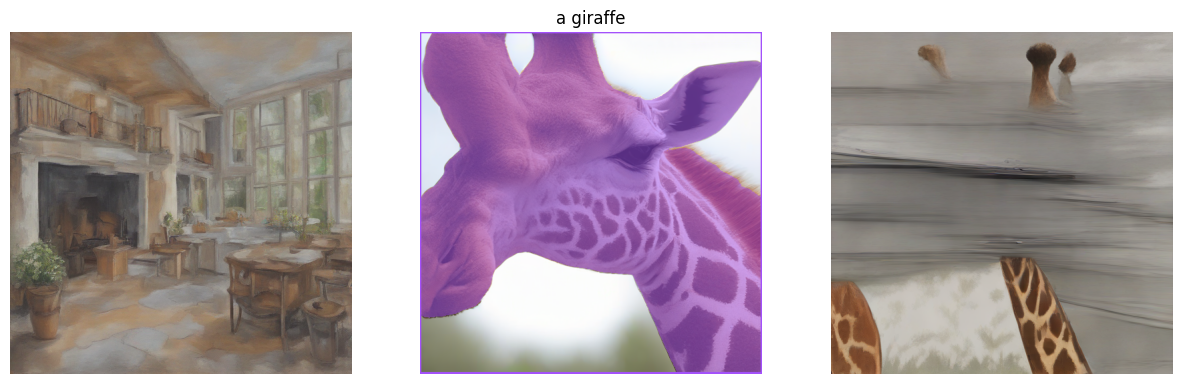

In [52]:
# ablation 
# "quantile", and combine_blocks are good choices
main("", "a giraffe", "#everything", "giraffe", 
    blocks_to_intervene=["down.2.1", "up.0.1", "up.0.0", "mid.0"],
    n_steps=1, m1=1.5, k_transfer=10, stat="quantile", k=10, mode="sae_ablation", 
    combine_blocks=True,
    result_name=None,)

processing blocks jointly...
tensor([42.1250], dtype=torch.float16) 1.0
down.2.1 [4338]
tensor([62.5938], dtype=torch.float16) 1.0
up.0.1 [3193]
tensor([102.6875,  86.8125,  68.1250], dtype=torch.float16) 1.0
up.0.0 [4655 1381 1941]
tensor([], dtype=torch.float16) 1.0
mid.0 []


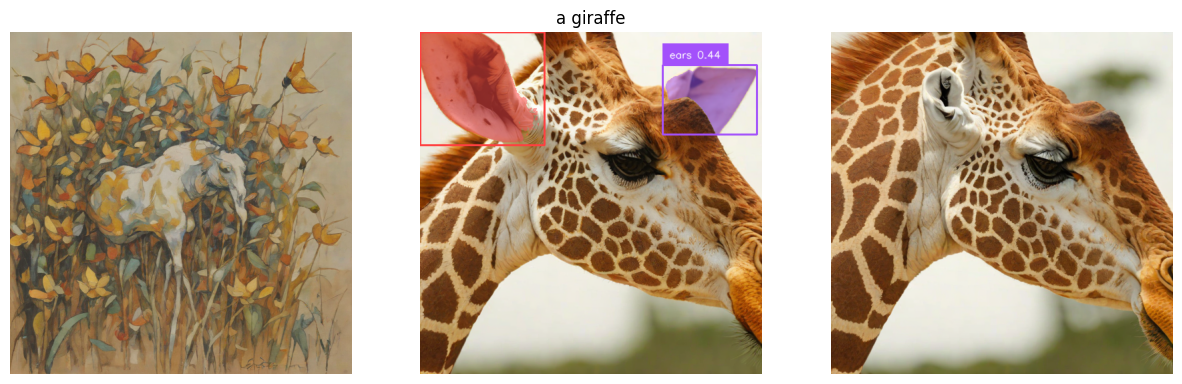

In [ ]:
# example for ablation
main("", "a giraffe", "#everything", "ears", 
    blocks_to_intervene=["down.2.1", "up.0.1", "up.0.0", "mid.0"],
    n_steps=4, m1=1.00, k_transfer=5, stat="quantile", k=10, mode="sae_ablation", 
    combine_blocks=True,
    result_name=None,)

In [ ]:
main("a giraffe", "2 people", "giraffe", "person", 
                    blocks_to_intervene=["down.2.1"],
                    n_steps=1, m1=1, k_transfer=3, stat="quantile", k=10, mode="sae_1", 
                    result_name=None)

In [ ]:
main("a giraffe", "a photo of a colorful model", "giraffe", "face", 
                    blocks_to_intervene=["up.0.1"],#.0.1"],
                    n_steps=4, m1=1.5, k_transfer=1, stat="quantile", k=10, mode="sae_1", 
                    result_name=None)

In [ ]:
main("a giraffe", "a photo of a colorful model", "giraffe", "face", 
                    blocks_to_intervene=["up.0.1"],#.0.1"],
                    n_steps=4, m1=5.5, k_transfer=10, stat="quantile", k=10, mode="sae_1", 
                    result_name=None)

In [ ]:
main("a white raven sitting on a branch", "a black raven sitting on a branch", "white raven", "black raven", 
                    blocks_to_intervene=["up.0.1"],
                    n_steps=1, m1=1., k_transfer=1, stat="quantile", k=10, mode="sae_1", 
                    result_name=None)

In [ ]:
main("a white raven sitting on a branch", "a black raven sitting on a branch", "white raven", "black raven", 
                    blocks_to_intervene=["up.0.1"],
                    n_steps=1, m1=3., k_transfer=1, stat="quantile", k=10, mode="sae_2", 
                    result_name=None)

In [ ]:
main("a face  with two open eyes", "a face with two closed eyes", "open eye", "closed eye", 
                    blocks_to_intervene=["up.0.0", "down.2.1"],# "up.0.0"],
                    n_steps=4, m1=5., k_transfer=3, stat="quantile", k=10, mode="sae_2", 
                    result_name=None, verbose=False)

In [ ]:
main("a face  with two open eyes", "a face with two closed eyes", "open eye", "closed eye", 
                    blocks_to_intervene=["up.0.0", "down.2.1"],# "up.0.0"],
                    n_steps=4, m1=1.5, k_transfer=5, stat="quantile", k=10, mode="sae_1", 
                    result_name=None, verbose=False)

In [ ]:
main("a man playing a guitar", "a man holding a fish", "guitar", "fish", 
    blocks_to_intervene=["up.0.0", "down.2.1"],# "up.0.0"],
    n_steps=4, m1=2., k_transfer=10, stat="quantile", k=10, mode="sae_1", 
    combine_blocks=True,
    result_name=None, verbose=False)

In [ ]:
main("a man playing a guitar", "a man holding a fish", "guitar", "fish", 
    blocks_to_intervene=["up.0.0", "down.2.1", "mid.0", "up.0.1"],# "up.0.0"],
    n_steps=4, m1=2., k_transfer=10, stat="quantile", k=10, mode="sae_1", 
    combine_blocks=True,
    result_name=None, verbose=False)

In [ ]:
main("a face  with two open eyes", "a face with two closed eyes", "open eye", "closed eye", 
                    blocks_to_intervene=["up.0.0", "down.2.1", "mid.0", "up.0.1"],
                    n_steps=4, m1=1.5, k_transfer=10, stat="quantile", k=10, mode="sae_1", 
                    combine_blocks=True, result_name=None, verbose=False)

import os
blocks_to_intervene = []
if use_down:
     blocks_to_intervene.append("down.2.1")
if use_up:
     blocks_to_intervene.append("up.0.1")
if use_up0:
     blocks_to_intervene.append("up.0.0")
if use_mid:
     blocks_to_intervene.append("mid.0")


for key, val in pb.items():
     if True or (int(val["editing_type_id"]) >= 0 and cnts[val["editing_type_id"]] < 10):
          try:
               if val["blended_word"] == "":
                    continue
               w1 = val["blended_word"].split(" ")[0]
               w2 = val["blended_word"].split(" ")[1]
               os.makedirs(f"../results/PIE-Bench/{n_steps}_{m1}_{k_transfer}_{use_down}_{use_up}_{use_up0}_{use_mid}/{val['editing_type_id']}", exist_ok=True)
               main(val["editing_prompt"], val["original_prompt"], w2, w1, 
                    blocks_to_intervene=blocks_to_intervene,
                    n_steps=n_steps, m1=m1, k_transfer=k_transfer, stat="max", k=10, mode="sae", 
                    result_name=f"../results/PIE-Bench/{n_steps}_{m1}_{k_transfer}_{use_down}_{use_up}_{use_up0}_{use_mid}/{val['editing_type_id']}/{key}")
               cnts[val["editing_type_id"]]+=1
          except Exception as e:
               print(e)
               continue
          